In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, \
    mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
import torch as tch
import torch.nn as nn

In [2]:
data_file_path = "../data/santander-value-prediction-challenge/"
df = pd.read_csv(data_file_path + "train.csv")

In [3]:
df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [4]:
df_y = df["target"]
predictors = [c for c in df.columns if c not in ["target", "ID"]]
df_X = df.loc[:, predictors]

<AxesSubplot:>

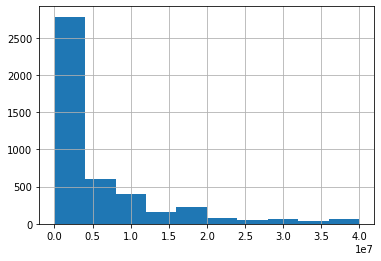

In [5]:
df_y.hist()

In [6]:
df_y.describe()

count    4.459000e+03
mean     5.944923e+06
std      8.234312e+06
min      3.000000e+04
25%      6.000000e+05
50%      2.260000e+06
75%      8.000000e+06
max      4.000000e+07
Name: target, dtype: float64

In [7]:
set(df_X.dtypes.values)

{dtype('int64'), dtype('float64')}

In [8]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_y, test_size=0.2)

In [9]:
X_train = tch.from_numpy(df_X_train.values).float()
X_test = tch.from_numpy(df_X_test.values).float()
y_train = tch.from_numpy(df_y_train.values).float().reshape(-1, 1)
y_test = tch.from_numpy(df_y_test.values).float().reshape(-1, 1)

In [10]:
X_train.shape

torch.Size([3567, 4991])

In [11]:
device = "cuda" if tch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [12]:
class Model(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        tch.manual_seed(2022)
        self._pipeline = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(4991, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self._pipeline(x)
        

In [13]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super(RMSLELoss, self).__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return tch.sqrt(self.mse(tch.log(pred + 1), tch.log(actual + 1)))

In [14]:
# Define the loss function
loss_function = nn.MSELoss()

# Hyperparameters

# Create a model instance
model = Model()

# Define optimizer
optimizer = tch.optim.Adam(model.parameters(), weight_decay=0.0001)

In [15]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: Model(
  (_pipeline): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=4991, out_features=100, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=100, out_features=100, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.1, inplace=False)
    (10): Linear(in_features=100, out_features=1, bias=True)
    (11): ReLU()
  )
)


Layer: _pipeline.1.weight | Size: torch.Size([100, 4991]) | Values : tensor([[-0.0029,  0.0119,  0.0073,  ...,  0.0033, -0.0113, -0.0014],
        [-0.0065, -0.0084,  0.0032,  ...,  0.0135, -0.0104, -0.0123]],
       grad_fn=<SliceBackward0>) 

Layer: _pipeline.1.bias | Size: torch.Size([100]) | Values : tensor([0.0114, 0.0007], grad_fn=<SliceBackward0>) 

Layer: _pipeline.4.weight | Size: torch.Size([100, 100]) | Values : tensor([[ 9.6473e-02, -2.8440e-02,  6.2002e-0

In [21]:
def train_network(model, optimizer, loss_function, X_train, y_train, num_epochs=100, batch_size=1000):
    losses = []
    model.train()
    for epoch in range(num_epochs):
        loss = 0.0
        for batch_start_index in range(0, X_train.shape[0], batch_size):
            
            X_ = X_train[batch_start_index : min(X_train.shape[0], batch_start_index + batch_size)]
            y_ = y_train[batch_start_index : min(X_train.shape[0], batch_start_index + batch_size)]

            optimizer.zero_grad()

            f_x = model(X_)

            loss_ = loss_function(f_x, y_)
            loss += loss_.item() * X_.shape[0]

            loss_.backward()

            optimizer.step()
        
        # print(f"Epoch {epoch} loss: {loss}")
        losses.append(loss / X_train.shape[0])

    return losses

Text(0.5, 0, 'Epochs')

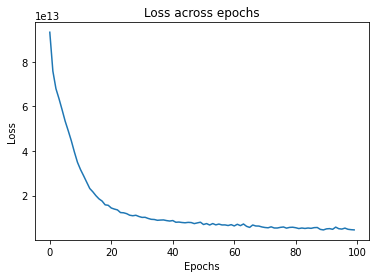

In [17]:
losses = train_network(model, optimizer, loss_function, X_train, y_train)
plt.plot(losses)
plt.title('Loss across epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')

In [18]:
def evaluate_model(model, X, y):

    model.eval()

    y_hat = model(X).detach().numpy()

    mae = mean_absolute_error(y, y_hat)
    mape = mean_absolute_percentage_error(y, y_hat)
    rmse = mean_squared_error(y, y_hat, squared=False)
    rmsle = mean_squared_log_error(y, y_hat, squared=False)
    

    print(f"MAE={mae}, MAPE={mape}, RMSE={rmse}, RMSLE={rmsle}")

    plt.scatter(y, y_hat)
    plt.title("Actuals vs Predictions")


MAE=750865.75, MAPE=0.6713222861289978, RMSE=1555561.875, RMSLE=2.171539545059204


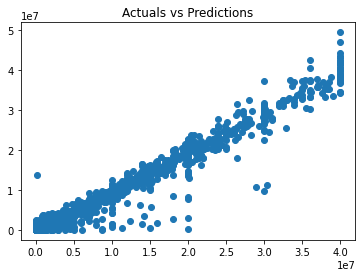

In [19]:
evaluate_model(model, X_train, y_train)

MAE=7911550.5, MAPE=10.498246192932129, RMSE=67636136.0, RMSLE=2.1225388050079346


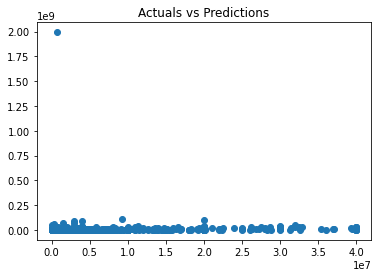

In [20]:
evaluate_model(model, X_test, y_test)